# Application of Post-hoc Interpretability technique: SHAP

SHAP (SHapley Additive exPlanations) for post-hoc interpretability in Loan Defaulter Prediction. SHAP is a method for creating a linear model of feature importance for a specific prediction. It is based on the Shapely values from Game Theory which satisfy the three important properties of local accuracy, missingness, and consistency.

The Lending Club Loan Dataset available on Kaggle has been used for this task: https://www.kaggle.com/datasets/wordsforthewise/lending-club

In [1]:
# Importing the required libraries.

import pathlib
import category_encoders
import lightgbm as lgb
import lime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.api.types
import seaborn as sns
import shap
import sklearn.base
import sklearn.dummy
import sklearn.impute
import sklearn.linear_model
import sklearn.model_selection
import sklearn.pipeline
import yaml
%matplotlib inline

C:\Users\44743\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\44743\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\44743\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Specifying the path to the dataset.

data_dir = pathlib.Path('./p2p_loans_470k/')
feature_schema_yaml = data_dir / 'feature_schema.yaml'
label_schema_yaml = data_dir / 'label_schema.yaml'
train_feature_csv = data_dir / 'train' / 'train_features.csv.gz'
train_label_csv = data_dir / 'train' / 'train_labels.csv.gz'
feature_schema_yaml
data_dir

WindowsPath('p2p_loans_470k')

In [3]:
%%time
with feature_schema_yaml.open() as yaml_file:
    feature_schema = yaml.safe_load(yaml_file)
with label_schema_yaml.open() as yaml_file:
    label_schema = yaml.safe_load(yaml_file)
train_features = pd.read_csv(train_feature_csv, **feature_schema)
train_labels = pd.read_csv(train_label_csv, **label_schema)

CPU times: total: 4.16 s
Wall time: 4.17 s


### Data Preprocessing

In [4]:
train_labels['issue_d'].dt.to_period('M').value_counts(normalize=True).sort_index(ascending=False).cumsum().head(5)
is_validation = train_labels['issue_d'] >= '2015-01'
validation_features = train_features.loc[is_validation, :]
train_features = train_features.loc[~is_validation, :]
validation_labels = train_labels.loc[is_validation, :]
train_labels = train_labels.loc[~is_validation, :]
train_target = train_labels['loan_status'].eq('Charged Off')
val_target = validation_labels['loan_status'].eq('Charged Off')
drop_features = train_features.select_dtypes(['datetime', 'O']).columns.tolist()
print('Dropping: ', drop_features)
train_features.drop(columns=drop_features, inplace=True)
validation_features.drop(columns=drop_features, inplace=True)
most_missing_cols = train_features.isna().mean().sort_values(ascending=False)
most_missing_cols.head()
drop_features = most_missing_cols.index.tolist()[:4]
print('Dropping: ', drop_features)
train_features.drop(columns=drop_features, inplace=True)
validation_features.drop(columns=drop_features, inplace=True)

Dropping:  ['emp_title', 'desc', 'title', 'earliest_cr_line']
Dropping:  ['mths_since_last_record', 'mths_since_last_major_derog', 'mths_since_recent_revol_delinq', 'mths_since_last_delinq']


In [5]:
cat_trim = {'home_ownership': 0.005, 'addr_state': 0.005}

In [6]:
def confusion_matrix(true, pred, threshold=0.5):
    # compute confusion matrix
    confusion_matrix = pd.DataFrame(
        sklearn.metrics.confusion_matrix(true, pred > threshold),
        index=['Fully Paid', 'Charged Off'],
        columns=['Fully Paid', 'Charged Off'],
    )
    confusion_matrix = confusion_matrix.div(confusion_matrix.sum(axis=1), axis=0)
    sns.heatmap(confusion_matrix, annot=True, vmin=0, vmax=1)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.yticks(rotation=0)
    plt.show()
    
def roc_curve_graph(true, pred, name):
    fpr, tpr, _ = sklearn.metrics.roc_curve(true, pred)
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    plt.figure(figsize=(4, 4))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) curve for "%s"' % name)
    plt.legend(loc="lower right")
    plt.show()

def evaluate(true, pred, name, confusion_thresh=0.15):
    log_loss = sklearn.metrics.log_loss(true, pred)
    auc = sklearn.metrics.roc_auc_score(true, pred)
    print(f'Log-loss: {log_loss: .4f} | AUC: {auc: .4f}')
    roc_curve_graph(true, pred, name)

def conf_matrices(confusion_thresh, true, pred):
    try:
        confusion_thresh = iter(confusion_thresh)
    except TypeError:
        confusion_thresh = iter([confusion_thresh])
    for thresh in confusion_thresh:
        print(f'Confusion matrix at threshold = {thresh}:')
        confusion_matrix(true, pred, thresh)

In [7]:
class DatasetPreprocessor:
    def __init__(self, nan_strategy='impute', scaling=True):
        self._raise_on_invalid_nan_strategy(nan_strategy)
        self.nan_strategy = nan_strategy
        self.scaling = scaling
        self.imputer = None
        self.categorical_encoder = None
        self.scaler = None
    
    def fit(self, features_df):
        self.categorical_encoder = category_encoders.OneHotEncoder(
            cols=features_df.select_dtypes('category').columns.tolist(),
            handle_unknown='ignore', use_cat_names=True)
        self.categorical_encoder.fit(features_df)
        df = self.categorical_encoder.transform(features_df)
        if self.nan_strategy == 'impute':
            self.imputer = sklearn.impute.SimpleImputer()
            self.imputer.fit(df)
            df[:] = self.imputer.transform(df)
        if self.scaling:
            self.scaler = sklearn.preprocessing.StandardScaler()
            self.scaler.fit(df)
        
    def transform(self, features_df):
        df = self.categorical_encoder.transform(features_df)
        if self.nan_strategy == 'impute':
            df[:] = self.imputer.transform(df)
        if self.scaling:
            df[:] = self.scaler.transform(df)
        if self.nan_strategy == 'sentinel':
            df.fillna(-999, inplace=True)

        return df
        
    @staticmethod
    def _raise_on_invalid_nan_strategy(strategy):
        supported = ('impute', 'sentinel')
        if strategy not in supported:
            raise ValueError(f'NaN strategy must be one of '
                             f'{supported}, but instead you '
                             f'passed "{stragegy}"')

In [8]:
%%time
bst_preprocessor = DatasetPreprocessor('impute')
bst_preprocessor.fit(train_features)
bst_train_features = bst_preprocessor.transform(train_features)
bst_val_features = bst_preprocessor.transform(validation_features)

CPU times: total: 17.7 s
Wall time: 17.9 s


In [9]:
lgb_train_data = lgb.Dataset(bst_train_features, label=train_target)

In [10]:
train_features['home_ownership'].unique().shape[0], len([x for x in train_features.columns if 'home_ownership' in x])

(6, 1)

### Training the LightGBM  Model

In [11]:
%%time
bst = lgb.train({}, lgb_train_data)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6021
[LightGBM] [Info] Number of data points in the train set: 294520, number of used features: 125
[LightGBM] [Info] Start training from score 0.132446
CPU times: total: 18.2 s
Wall time: 2.25 s


In [12]:
%%time
background_data = bst_train_features.sample(20000, random_state=3)
background_means = shap.kmeans(background_data, k=30)

CPU times: total: 37.5 s
Wall time: 3.42 s


In [13]:
predictor_function_bst = lambda x: bst.predict(x)
explainer_bst = shap.KernelExplainer(predictor_function_bst, background_means)

In [14]:
pred_bst = pd.Series(bst.predict(bst_val_features), index=bst_val_features.index)
selected_indices_bst = pred_bst.sample(n=1000, random_state=1).index
selected_examples_bst = bst_val_features.loc[selected_indices_bst, :]

### SHAP Values vs Information Gain Values

In [15]:
shap_values_bst = explainer_bst.shap_values(selected_examples_bst, l1_reg='num_features(20)')

  0%|          | 0/1000 [00:00<?, ?it/s]

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.


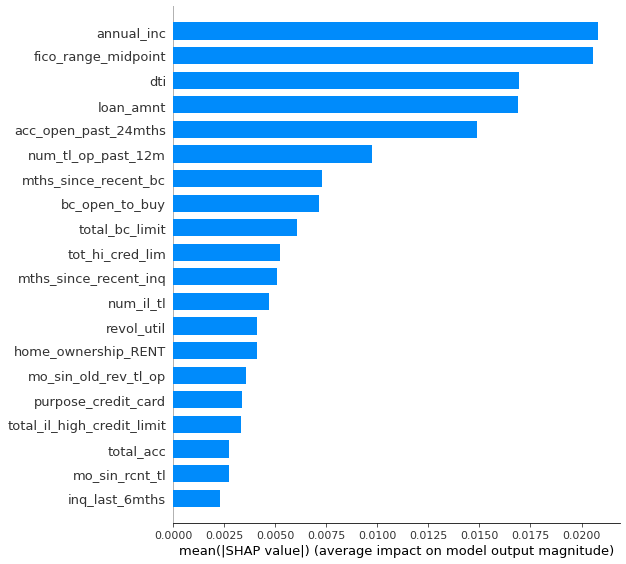

In [16]:
shap.summary_plot(shap_values_bst, selected_examples_bst, plot_type="bar")

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


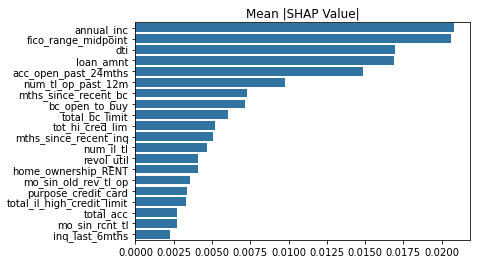

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


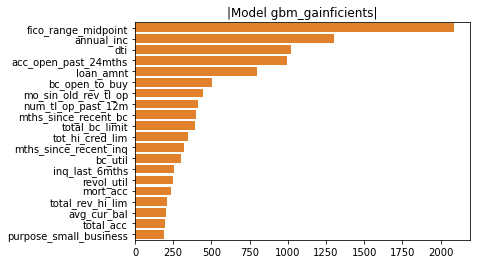

Total absolute SHAP values: 0.19 | Total absolute model gbm_gainficients: 13581.57


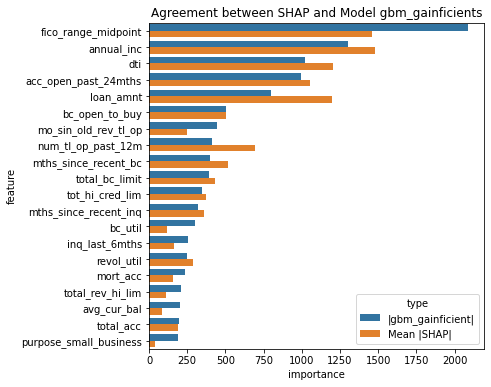

In [17]:
gain_importances = pd.Series(bst.feature_importance(importance_type='gain'),
                             index=bst_train_features.columns)
sorted_by_abs_val = gain_importances.abs().sort_values(ascending=False).index
gain_importances = gain_importances[sorted_by_abs_val]
mean_shap_importances = (pd.DataFrame(shap_values_bst, columns=selected_examples_bst.columns)
                         .abs()
                         .mean()
                         .sort_values(ascending=False))
top_20_mean = mean_shap_importances.head(20)
sns.barplot(top_20_mean, top_20_mean.index, color=sns.color_palette()[0])
plt.title('Mean |SHAP Value|')
plt.show()

top_20_gbm_gain = gain_importances.abs().head(20)
sns.barplot(top_20_gbm_gain, top_20_gbm_gain.index, color=sns.color_palette()[1])
plt.title('|Model gbm_gainficients|')
plt.show()

print(f'Total absolute SHAP values: {mean_shap_importances.sum():.2f} | '
      f'Total absolute model gbm_gainficients: {gain_importances.abs().sum():.2f}')
adj_ratio = gain_importances.abs().sum() / mean_shap_importances.sum()

top_20_gbm_gain.name = '|gbm_gainficient|'
mean_shap_importances.name = 'Mean |SHAP|'
combo_df = (top_20_gbm_gain.to_frame()
            .join(mean_shap_importances.to_frame() * adj_ratio)
            .reset_index()
            .rename(columns={'index':'feature'})
            .melt(id_vars='feature', 
                  var_name='type', 
                  value_name='importance'))

plt.figure(figsize=(6,6))
sns.barplot(y='feature', x='importance', hue='type', data=combo_df)
plt.title('Agreement between SHAP and Model gbm_gainficients')
plt.show()

### SHAP Summary Plot

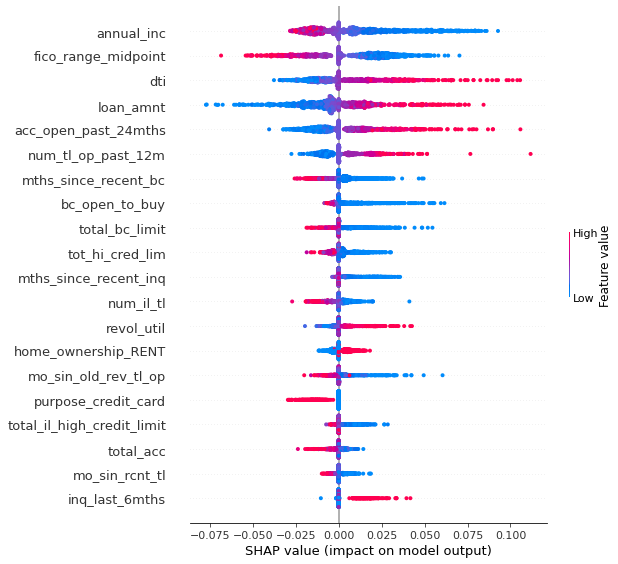

In [18]:
shap.summary_plot(shap_values_bst, selected_examples_bst)